# Finetuning on smart home data

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,HfArgumentParser,TrainingArguments,pipeline, logging
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os, torch
from datasets import load_dataset, load_from_disk
import datasets
from trl import SFTTrainer
import pandas as pd
import json

In [2]:
print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

torch.cuda.empty_cache()

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

True
A100-SXM-80GB


In [3]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 85198045184
free     : 38278463488
used     : 46919581696


In [4]:
base_model = "./mistral-7b-instruct-v02"
new_model = "custom-finetuned_mistral-7b-instruct-v02-18"

In [5]:
merged_df = pd.read_csv('training_data_encoded-17.csv')

In [5]:
df_implicit = pd.read_csv('training_data_encoded-15.csv')
df_normal = pd.read_csv('training_data_encoded-13.csv')
df_generated = pd.read_csv('training_data_encoded-18.csv')

merged_df = pd.concat([df_normal, df_implicit, df_generated], ignore_index=True)
# Display the first element of merged_df
print(merged_df.loc[0, 'train'])

# Display the last element of merged_df
print(merged_df.iloc[-1, merged_df.columns.get_loc('train')])

<s>[INST] 

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - argum

In [6]:
dataset = datasets.Dataset.from_pandas(merged_df)

In [7]:
dataset

Dataset({
    features: ['train'],
    num_rows: 448
})

In [8]:
model = AutoModelForCausalLM.from_pretrained(
        base_model,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
        trust_remote_code=True,
)

model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

(True, True)

Map:   0%|          | 0/448 [00:00<?, ? examples/s]

448


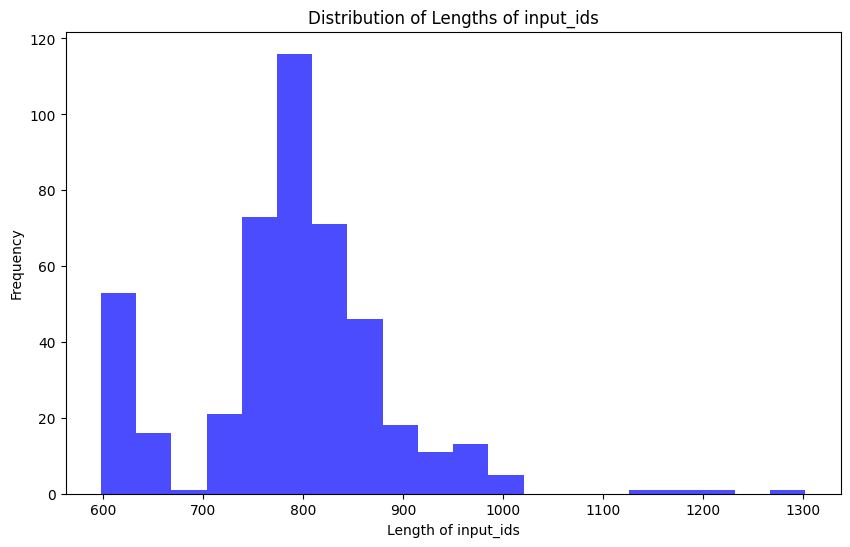

In [9]:
import matplotlib.pyplot as plt

def formatting_func(example):
    text = f"{example['train']}"
    return text

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenized_train_dataset = dataset.map(generate_and_tokenize_prompt)

def plot_data_lengths(tokenize_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset)

In [10]:
# model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
    target_modules="all-linear" 
)
model = get_peft_model(model, peft_config)

In [11]:
training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4, # change to 2e-5
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

In [12]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length= None,
    dataset_text_field="train",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/transformers/training_args.py:1961: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:278: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument t

Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
trainer.train()

Step,Training Loss
25,0.442400
50,0.110000
75,0.083900
100,0.068800
125,0.048200
150,0.039500
175,0.036100
200,0.040700
225,0.033100
250,0.022800


/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in ./mistral-7b-instruct-v02 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in ./mistral-7b-instruct-v02 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in ./mistral-7b-instruct-v02 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in ./mistral-7b-instruct-v02 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/jovyan/miniconda3/envs/griham/lib/python3.

TrainOutput(global_step=1680, training_loss=0.02728100201735894, metrics={'train_runtime': 2239.2191, 'train_samples_per_second': 3.001, 'train_steps_per_second': 0.75, 'total_flos': 2.3338298851609805e+17, 'train_loss': 0.02728100201735894, 'epoch': 15.0})

In [14]:
trainer.model.save_pretrained(new_model)
model.config.use_cache = True
model.eval()

/home/jovyan/miniconda3/envs/griham/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in ./mistral-7b-instruct-v02 - will assume that the vocabulary was not modified.
  warnings.warn(


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_fe

In [18]:
sys_prompt = """

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object ONLY contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - arguments: Dictionary of arguments for the function_name, which are required for execution of the function. (e.g., device, location, application, title, etc.)
Only have function name and arguments. Do not output any other fields like description. 

Do not add any superfluous steps. Make sure that each step has all the information needed - do not skip steps.
If it is impossible to generate step by step plan, reply empty list of function.

Use only relavant devices from the homecontext. Do not add devices which are not required.

"""

In [19]:
func = """ The functions you can use are: 
 {
            
            "function": [
                {
                    "name": "identify_device",
                    "description": "Infer the device name or type from the user utterance or prompt the user if inference is not possible.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "device": {
                                "type": "string",
                                "description": "Target device to be used."
                            },
                            "location": {
                                "type": "string",
                                "description": "Target location to be used"
                            }
                        },
                        "required": ["device"]
                    }
                },
                {
                    "name": "launch_app",
                    "description": "This function is used to launch an application on TV device.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "device": {
                                "type": "string",
                                "description": "Target device to be used."
                            },
                            "appName": {
                                "type": "string",
                                "description": "Target application to be used"
                            },
                            "title": {
                                "type": "string",
                                "description": "Target title to be searched and played"
                            }
                        },
                        "required": ["device", "appName"]
                    }
                },
                {
                    "name": "set_channel",
                    "description": "This function is used to set a channel on TV device.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "device": {
                                "type": "string",
                                "description": "Target device to be used."
                            },
                            "channel": {
                                "type": "string",
                                "description": "Target channel to be used"
                            }
                        },
                        "required": ["device", "channel"]
                    }
                }, 
                
            ]
        }"""

In [20]:
user_query = """Play fall out 76 on netflix in my living room"""

In [30]:
logging.set_verbosity(logging.CRITICAL)

prompt = sys_prompt + """ @@@ """ + user_query + " @@@ " 
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=8000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object ONLY contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - 

In [31]:
print(result[0]['generated_text'].split('%%%%%%%')[4])

 {"type": "function", "function": [{"name": "identify_device", "arguments": {"device": "TV", "location": "Living Room"}}, {"name": "powerSwitch_getStatus", "arguments": {"device": "#E1"}}, {"name": "device_turnOn", "arguments": {"device": "#E1"}}, {"name": "launch_app", "arguments": {"device": "#E1", "application": "Netflix", "title": "Fallout 76"}}]} [/INST]The living room TV has started playing Fallout 76 on Netflix.


In [32]:
user_query = """After turning off the lights Play fall out 76 on netflix in my living room"""
logging.set_verbosity(logging.CRITICAL)

prompt = sys_prompt + """@@@ """ + user_query + "@@@" + ""
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'].split('%%%%%%%')[3])


 {"type": "function", "function": [{"name": "identify_device", "description": "Infer the device name or type from the user utterance or prompt the user if inference is not possible.", "parameters": {"type": "object", "properties": {"device": {"type": "string", "description": "Smart home IoT device to be used. Such as TV, AC, Washing Machine etc."}, "location": {"type": "string", "description": "Smart home IoT location to be used. Such as living room, bedroom, kitchen etc."}}, "required": ["device"]}}, {"name": "launch_app", "description": "This function is used to launch an application on TV device.", "parameters": {"type": "object", "properties": {"device": {"type": "string", "description": "Target device to be used."}, "appName": {"type": "string", "description": "Target application to be used"}, "title": {"type": "string", "description": "Target title to be searched and played"}}, "required": ["device", "appName"]}}]}] [/INST] 


In [33]:
result[0]['generated_text']

'<s>[INST] \n\nYou are a smart home IOT agent.\nYou will be given a user command enclosed within @@@ Task @@@.\n\nYou have to generate step by step execution plan for the given user command in json format enclosed between !!!:\n!!!\n%%%%%%%\n{\n\n    "tool_calls": [\n        {\n            "function_name": "function 1",\n            "arguments": \n                {\n                    "argument_name 1": "argument value"\n                }\n         },\n         {\n            "function_name": "function 2",\n            "arguments": \n                {\n                    "argument_name 1": "argument value",\n                    "argument_name 2": "argument value"\n                }\n        }\n    ]\n}\n%%%%%%%\n!!!\nKeywords are defined as below:\n\ntool_calls: List of tool call objects, where each tool call object ONLY contains:  \n    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or 

In [33]:
user_query = """ Turn on junk command """
logging.set_verbosity(logging.CRITICAL)

prompt = sys_prompt + """@@@ """ + user_query + "@@@" + ""
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object ONLY contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - 

In [ ]:
user_query = """ Turn on junk command """
logging.set_verbosity(logging.CRITICAL)

prompt = sys_prompt + """@@@ """ + user_query + "@@@" + ""
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [39]:
sys_prompt_implicit = """

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - arguments: Dictionary of arguments for the function_name, which are required for execution of the function. (e.g., device, location, application, title, etc.)

Use homecontext to understand the devices, and only consider devices mentioned in the homecontext data. Do not generate prediction for irrelavant devices.

Do not add any superfluous steps. Make sure that each step has all the information needed - do not skip steps.
If it is impossible to generate step by step plan, reply empty list of function. Ensure to enclose the output with "%%%%%%%" after generating with the json format. Do not generate anything after the second %%%%%%%.



"""

In [40]:
user_query = """Create a soothing environment"""
logging.set_verbosity(logging.CRITICAL)

prompt = sys_prompt_implicit + """@@@ """ + user_query + "@@@" + ""
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 

You are a smart home IOT agent.
You will be given a user command enclosed within @@@ Task @@@.

You have to generate step by step execution plan for the given user command in json format enclosed between !!!:
!!!
%%%%%%%
{

    "tool_calls": [
        {
            "function_name": "function 1",
            "arguments": 
                {
                    "argument_name 1": "argument value"
                }
         },
         {
            "function_name": "function 2",
            "arguments": 
                {
                    "argument_name 1": "argument value",
                    "argument_name 2": "argument value"
                }
        }
    ]
}
%%%%%%%
!!!
Keywords are defined as below:

tool_calls: List of tool call objects, where each tool call object contains:  
    - function_name: It is name of single execution step for the complete plan. (e.g., identify_device, powerSwitch_getStatus, etc.) Plan can have 1 or more functions in response.
    - argum

In [47]:
print(result[0]['generated_text'].split('%%%%%%%')[5])

 {"type": "function", "function": [{"name": "media_play", "arguments": {"device": "TV1", "appName": "Youtube", "title": "relaxing music"}}, {"name": "airConditioningMode_setValue", "arguments": {"device": "AC1", "mode": "WindFree"}}, {"name": "colorMode_setValue", "arguments": {"device": "L1", "mode": "relaxing"}}]} 


In [34]:
import pandas as pd
history = pd.DataFrame(trainer.state.log_history)
history

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4508,0.269531,0.0002,0.280899,25,NaN,NaN,NaN,NaN,NaN
1,0.1074,0.112793,0.0002,0.561798,50,NaN,NaN,NaN,NaN,NaN
2,0.0622,0.074219,0.0002,0.842697,75,NaN,NaN,NaN,NaN,NaN
3,0.0450,0.078125,0.0002,1.123596,100,NaN,NaN,NaN,NaN,NaN
4,0.0360,0.046143,0.0002,1.404494,125,NaN,NaN,NaN,NaN,NaN
5,0.0297,0.082031,0.0002,1.685393,150,NaN,NaN,NaN,NaN,NaN
6,0.0358,0.132812,0.0002,1.966292,175,NaN,NaN,NaN,NaN,NaN
7,0.0273,0.060547,0.0002,2.247191,200,NaN,NaN,NaN,NaN,NaN
8,0.0255,0.106934,0.0002,2.528090,225,NaN,NaN,NaN,NaN,NaN
9,0.0286,0.062500,0.0002,2.808989,250,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='step'>

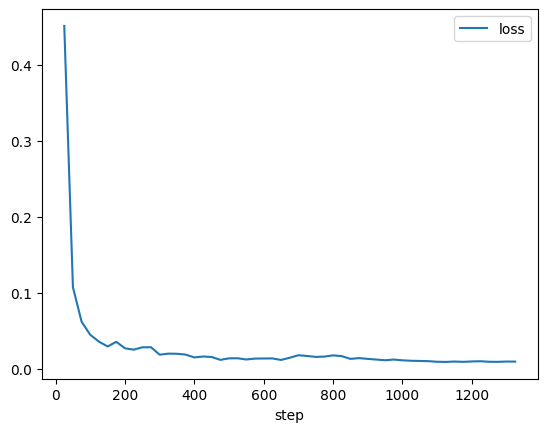

In [35]:
history.plot('step','loss')

In [36]:
history.tail()

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
49,0.0096,0.013367,0.0002,14.044944,1250,NaN,NaN,NaN,NaN,NaN
50,0.0095,0.019043,0.0002,14.325843,1275,NaN,NaN,NaN,NaN,NaN
51,0.0099,0.020142,0.0002,14.606742,1300,NaN,NaN,NaN,NaN,NaN
52,0.0098,0.016724,0.0002,14.887640,1325,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,15.000000,1335,1762.5283,3.021,0.757,1.829905e+17,0.027167


In [37]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()